In [ ]:
#########################################################
# Visual Geometry HOMEWORK - 2
# Lecturer : Jongwon Choi (GSAIM, Chung-Ang University)
# Date : 2020.10.19
#########################################################

#################  DONT TOUCH  ########################
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#################  DONT TOUCH  ########################

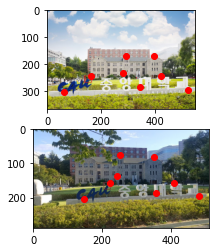

In [ ]:
#################  DONT TOUCH  ########################
## Image Read & Point Picking (Square Region)
img1, img2 = mpimg.imread('./cau1.jpg'), mpimg.imread('./cau2.jpg')

## Correspondence points (Ex. pts1[0] <-> pts2[0], pts1[1] <-> pts2[1], ...)
# points on img1
pts1 = [[164,243],[345,284],[422,245],[524,295],[398,169],[293,169],[63,304],[283,232]] #correct correspondences
pts1_test = [[125,298],[209,194],[200,253],[315,260],[164,243],[345,284],[422,245],[524,295],
             [398,169],[293,169],[63,304],[283,232],[10,20],[310,220],[13,210],
             [1123,321],[49,103],[133,603],[312,682]]


# points on img2
pts2 = [[225,156],[357,186],[411,156],[483,196],[351,80],[254,76],[147,205],[243,138]] #correct correspondences
pts2_test = [[195,199],[174,98],[253,162],[337,168],[225,156],[357,186],[411,156],[483,196],
             [351,80],[254,76],[147,205],[243,138],[100,200],[100,230],[68,390],
             [8,1],[200,300],[17,95],[92,100]]

pts1, pts2 = np.asarray(pts1), np.asarray(pts2)
pts1_test, pts2_test = np.asarray(pts1_test), np.asarray(pts2_test)

## image plot
fig = plt.figure()
ax1, ax2 = fig.add_subplot(2, 1, 1), fig.add_subplot(2, 1, 2)

ax1.imshow(img1)
ax1.scatter(pts1[:,0], pts1[:,1], color='r')
ax2.imshow(img2)
ax2.scatter(pts2[:,0], pts2[:,1], color='r')
#################  DONT TOUCH  ########################

In [ ]:
## Coordinates Transformation

# to homogeneous
def hmgCoord(inhomo):
    if not type(inhomo) == np.array:
      inhomo = np.array(inhomo)

    one = np.ones((1, inhomo.shape[0]))
    homo = np.concatenate((inhomo.T, one), axis=0)
    return homo


# to inhomogeneous
def inhmgCoord(homo):
    inhomo = homo[0:2, :].T
    return inhomo

In [ ]:
## Problem 1
## Fundamental Matrix Estimation (USE ONLY NUMPY LIBRARY)
# Using the correct correspondences (pts1, pts2)
F_correct = np.identity(3)

#########################################################
#                    YOUR ANSWER HERE                   #

def compute_fundamental(p1, p2):
  """ u = [ux, uy].T
      v = [vx, vy].T
  """
  n, m = p1.shape[1], p2.shape[1]
  A = np.empty((n, 9))

  for i in range(n):
    ux, uy, _ = p1[:,i]
    vx, vy, _ = p2[:,i]
    A[i] = np.array([ux*vx, uy*vx, vx, ux*vy, uy*vy, vy, ux, uy, 1])

  U, D, VT = np.linalg.svd(A)
  F = VT[-1].reshape(3, 3)

  # constrain F
  # make rank(F) = 2
  U, D, VT = np.linalg.svd(F)
  D[-1] = 0
  S = np.diag(D)

  F = np.dot(U, np.dot(S, VT))
  return F / F[2, 2]


def normalizeCoord(p):
  p = p / p[2]
  mean = np.mean(p[:2], axis=1)
  S = np.sqrt(2) / np.std(p[:2])
  T = np.array([[S, 0, -S*mean[0]],
                [0, S, -S*mean[1]],
                [0, 0,         1]])
  nP = np.dot(T, p)
  return nP, T



def FundamentalMatrix(p1, p2):
  n, m = p1.shape[1], p2.shape[1]
  if n != m:
    raise ValueError("number of points don't match")
  elif n < 8:
    raise ValueError("At least 8 points needed")
    
  np1, T1 = normalizeCoord(p1)
  np2, T2 = normalizeCoord(p2)

  F = compute_fundamental(np1, np2)

  # denormalization
  F = np.dot(T1.T, np.dot(F, T2))
  return F / F[2, 2]


p1 = hmgCoord(pts1)
p2 = hmgCoord(pts2)

F_correct = FundamentalMatrix(p1, p2)



#########################################################

#Test the estimated fundamental matrix by using the unknown correspondences (pts1_test, pts2_test)
pts1_test_hom = np.concatenate((pts1_test, np.ones([pts1_test.shape[0], 1])), axis=1)
pts2_test_hom = np.concatenate((pts2_test, np.ones([pts2_test.shape[0], 1])), axis=1)
error = np.diagonal(pts1_test_hom @ F_correct @ pts2_test_hom.transpose())

print(error)
print(F_correct)

[ 4.39340801e-01  4.40117968e-02  9.70704314e-02  4.89130910e-02
  6.26253155e-02  1.61657368e-01 -1.16860181e-01 -3.84404409e-03
  5.00173417e-02  1.08661562e-01  5.29242028e-01 -1.20477568e-02
 -2.11619785e-01 -6.84054859e-01  1.04208252e+00  4.56356426e+00
 -6.11919477e-01 -1.44558449e+00 -2.08721022e-01]
[[-1.19612701e-06 -3.87724486e-05  5.33681655e-03]
 [ 3.58445640e-05  3.22238293e-05 -7.51414655e-03]
 [-7.94162074e-03 -2.21193183e-03  1.00000000e+00]]


In [ ]:
## Problem 2
## RANSAC Algorithm with Fundamental Matrix Estimation (USE ONLY NUMPY LIBRARY)
# Using the unknown correspondeces (pts1_test, pts2_test)

F_ransac = np.identity(3)
inliers = np.zeros(pts1_test.shape[0], dtype=np.bool)

# #########################################################
# #                    YOUR ANSWER HERE                   #
class RansacModel(object):
  def __init__(self,debug=False):
        self.debug = debug

  def fit(self, p1, p2):
    return FundamentalMatrix(p1, p2)

  def get_error(self, p1, p2, F):
    err = np.diag(p1.T @ F @ p2)
    return np.abs(err)


def FundamentalRansac(pts1, pts2, model, sample=8, th=1e-5, maxiter=5000):

  all_idx = np.arange(pts1.shape[0])
  max_inlier_cnt = 0
  best_F = None
  inliers = None

  for iter in range(maxiter):

    # randomly pick 8 corrs    
    sample_id = np.random.choice(all_idx, size=sample, replace=False)

    p1 = np.array([pts1[id] for idx, id in enumerate(sample_id)])
    p2 = np.array([pts2[id] for idx, id in enumerate(sample_id)])

    p1 = hmgCoord(pts1)
    p2 = hmgCoord(pts2)

    # estimate fundamental matrix
    maybe_F = model.fit(p1, p2)

    test1 = hmgCoord(pts1)
    test2 = hmgCoord(pts2)

    # apply F to all corrs    
    abs_err = model.get_error(test1, test2, maybe_F)

    # corrs with uT @ F @ v < th are inliers
    maybe_inliers = abs_err < th
    inlier_cnt = np.sum(maybe_inliers)

    # count and save inliers
    if inlier_cnt > max_inlier_cnt:
      best_F = maybe_F
      max_inlier_cnt = inlier_cnt
      inliers = maybe_inliers
      
  return best_F, inliers


model = RansacModel()
F_ransac, inliers = FundamentalRansac(pts1_test, pts2_test, model, th=0.8)


# #########################################################

# Print the inliers to reject the noisy correspondences
print(np.sum(inliers))
print(inliers)
print(F_ransac)

9
[ True  True  True False  True False False False False False  True  True
  True False  True False False False  True]
[[ 5.54671327e-06 -6.05912641e-05  5.96762891e-03]
 [ 3.40781707e-05  4.06324685e-05 -6.52732134e-03]
 [-3.44725965e-03 -7.35781422e-03  1.00000000e+00]]
